### Carrega e trata a base da pesquisa

In [1]:
# Carregar o CSV com tratamento adequado para campos com vírgulas
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

# Carregar o CSV usando pandas diretamente, com parâmetros específicos para lidar com as aspas
df = pd.read_csv(
    "dados/MQD_1465_final.csv",
    sep=',',              # separador de colunas
    quoting=csv.QUOTE_ALL,# trata todos os campos como strings entre aspas
    quotechar='"',        # caractere de aspas
    skipinitialspace=True # remove espaços após as vírgulas
)

# Remover espaços em branco dos nomes das colunas
df.columns = df.columns.str.strip()

# Verificar o tamanho do arquivo e as primeiras linhas
print("Dimensões do DataFrame:", df.shape)
print("\nPrimeiras linhas:")
print(df.head())

# Verificar nomes das colunas
print("\nColunas disponíveis:")
print(df.columns.tolist())

Dimensões do DataFrame: (1465, 22)

Primeiras linhas:
   ItemNumber                                              frase  \
0           1  Você sabia que o menino que mais vai te dar va...   
1           2  Hoje com 21 anos, como que por auxilio lá do a...   
2           3  Nesse momento to evitando ela, e ta me dando u...   
3           4  Meus sentidos de garota diziam que tinha algum...   
4           5  Aquela promessa que eu te fiz naquele natal, e...   

   cla_maj_femi  qtd_maj_femi  cla_maj_masc  qtd_maj_masc  f1_class  f2_class  \
0  positiva                 4  positiva                 4  positiva  positiva   
1  positiva                 4  positiva                 3  positiva  positiva   
2  negativa                 3  negativa                 2  negativa  negativa   
3  neutra                   2  neutra                   3  neutra    negativa   
4  positiva                 3  positiva                 3  positiva  positiva   

   f3_class  f4_class  ...  m3_class  m4_class f1_

### Verifica as distribuições

In [ ]:
# Distribuição das classes majoritárias femininas
print("\nDistribuição cla_maj_femi:")
print(df['cla_maj_femi'].value_counts(dropna=False))

# Distribuição das classes majoritárias masculinas
print("Distribuição cla_maj_masc:")
print(df['cla_maj_masc'].value_counts(dropna=False))





Distribuição cla_maj_femi:
cla_maj_femi
positiva        514
negativa        503
neutra          448
Name: count, dtype: int64
Distribuição cla_maj_masc:
cla_maj_masc
positiva        619
negativa        514
neutra          332
Name: count, dtype: int64


In [4]:
# Aplicando um crosstab para comparar as congruências entre gêneros
ct = pd.crosstab(df['cla_maj_masc'], df['cla_maj_femi'])
print("\nCrosstab das classes masculinas x femininas:")
print(ct)

#concordancia: 78,15%
#discordancia: 21,84%



Crosstab das classes masculinas x femininas:
cla_maj_femi  negativa      neutra        positiva    
cla_maj_masc                                          
negativa               435            65            14
neutra                  36           253            43
positiva                32           130           457


Total de registros analisados: 1465

Concordância total: 1145 registros (78.16%)
Discordância total: 320 registros (21.84%)

Detalhamento da concordância por classe:
         Classe  Total Concordância  % das Concordâncias
0  positiva                     457            39.912664
1  negativa                     435            37.991266
2  neutra                       253            22.096070


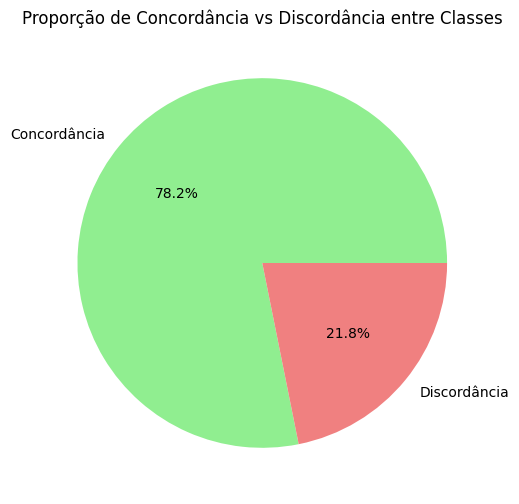

In [7]:
# Calculando concordância e discordância entre classes masculinas e femininas
total_registros = len(df)
concordancia = (df['cla_maj_masc'] == df['cla_maj_femi']).sum()
discordancia = (df['cla_maj_masc'] != df['cla_maj_femi']).sum()

# Calculando percentuais
perc_concordancia = (concordancia / total_registros) * 100
perc_discordancia = (discordancia / total_registros) * 100

# Criando um DataFrame para mostrar os detalhes da concordância por classe
concordancia_detalhada = pd.DataFrame({
    'Classe': df[df['cla_maj_masc'] == df['cla_maj_femi']]['cla_maj_masc'].value_counts()
})
concordancia_detalhada['Percentual'] = (concordancia_detalhada['Classe'] / concordancia) * 100
concordancia_detalhada.reset_index(inplace=True)
concordancia_detalhada.columns = ['Classe', 'Total Concordância', '% das Concordâncias']    


# Exibindo resultados
print(f"Total de registros analisados: {total_registros}")
print(f"\nConcordância total: {concordancia} registros ({perc_concordancia:.2f}%)")
print(f"Discordância total: {discordancia} registros ({perc_discordancia:.2f}%)")
print("\nDetalhamento da concordância por classe:")
print(concordancia_detalhada)

# Visualização gráfica
plt.figure(figsize=(10, 6))
plt.pie([concordancia, discordancia], 
        labels=['Concordância', 'Discordância'],
        autopct='%1.1f%%',
        colors=['lightgreen', 'lightcoral'])
plt.title('Proporção de Concordância vs Discordância entre Classes')
plt.show()

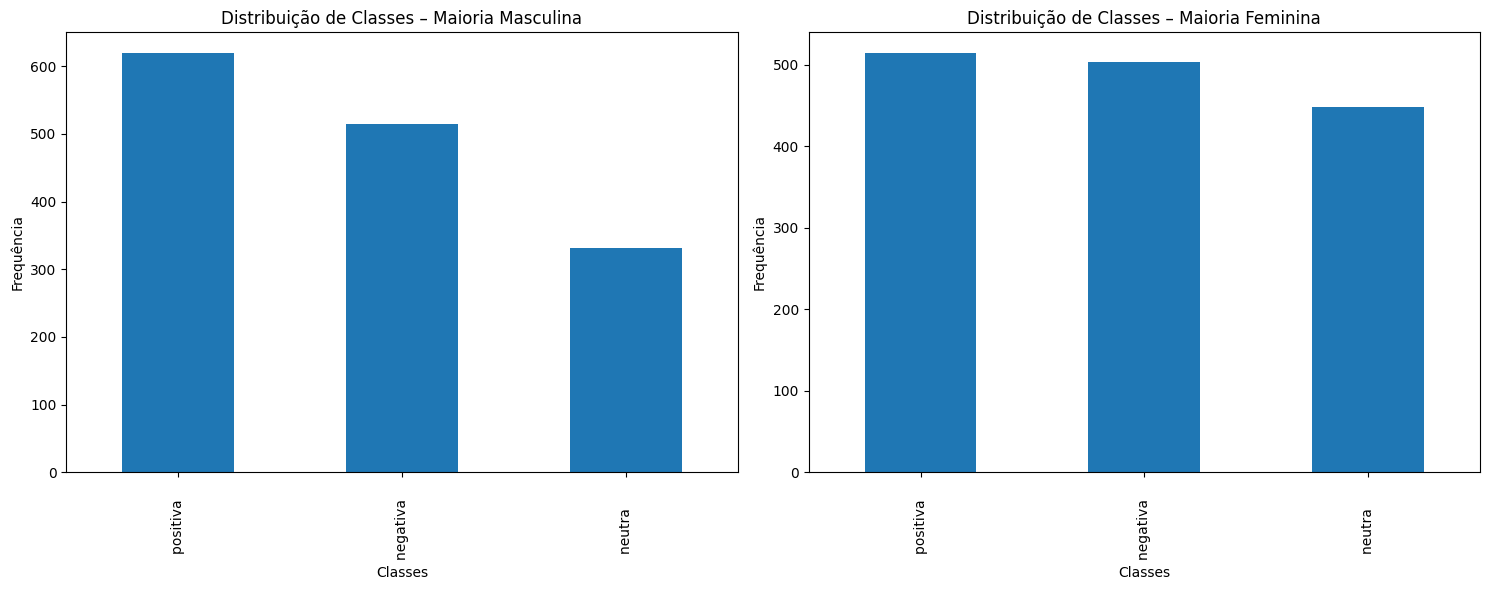

In [20]:
# Criando uma figura com dois subplots lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot para classes masculinas
df['cla_maj_masc'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title("Distribuição de Classes – Maioria Masculina")
ax1.set_xlabel("Classes")
ax1.set_ylabel("Frequência")

# Plot para classes femininas
df['cla_maj_femi'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title("Distribuição de Classes – Maioria Feminina")
ax2.set_xlabel("Classes")
ax2.set_ylabel("Frequência")

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar os gráficos
plt.show()

In [9]:
# Aplicaçao de um teste de independência (qui-quadrado)
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(ct)
print(f"Estatística qui-quadrado: {chi2}, p-valor: {p}")


Estatística qui-quadrado: 1348.6461779395033, p-valor: 9.434416363071011e-291


In [ ]:
# Calculo do Kappa de Fleiss
def fleiss_kappa(data_matrix):
    """
    Calcula o Kappa de Fleiss para uma matriz de contagens.
    Cada linha da matriz corresponde a um item,
    e cada coluna corresponde a uma categoria,
    contendo quantas vezes aquela categoria foi atribuída.

    Parâmetros
    ----------
    data_matrix : numpy.ndarray
        Matriz (itens x categorias).

    Retorno
    -------
    float
        Valor do Kappa de Fleiss.
    """
    N, k = data_matrix.shape  # N itens, k categorias
    n = np.sum(data_matrix[0])  # número de avaliadores por item (supõe-se o mesmo em todas as linhas)

    # P_i (índice de concordância) para cada item
    P_i = []
    for i in range(N):
        row = data_matrix[i, :]
        row_sum_sq = np.sum(row ** 2)
        # fórmula do P_i = (Σ(n_ij^2) - n) / [n * (n - 1)]
        P_i_item = (row_sum_sq - n) / (n * (n - 1))
        P_i.append(P_i_item)
    P_bar = np.mean(P_i)  # média dos P_i

    # p_j (proporção global de cada categoria j)
    p_j = np.sum(data_matrix, axis=0) / (N * n)  # soma por coluna / (N * n)
    P_bar_e = np.sum(p_j ** 2)  # soma dos quadrados das proporções

    # Kappa de Fleiss
    kappa = (P_bar - P_bar_e) / (1 - P_bar_e)
    return kappa


def compute_fleiss_kappa_for_raters(df, rater_cols, categories):
    """
    Converte as colunas de classificadores em uma matriz de contagens
    e calcula o Kappa de Fleiss.

    Parâmetros
    ----------
    df : pd.DataFrame
        DataFrame contendo as classificações.
    rater_cols : list
        Lista das colunas correspondentes aos avaliadores (e.g. ['f1_class','f2_class','m1_class','m2_class']).
    categories : list
        Lista de categorias possíveis (e.g. ['Positivo', 'Negativo', 'Neutro']).

    Retorno
    -------
    float
        Kappa de Fleiss para as colunas informadas.
    """
    # Se houver valores ausentes (NaN) em alguma das colunas de rater, podemos removê-los:
    df_valid = df.dropna(subset=rater_cols).copy()

    # Criar uma matriz (itens x categorias) com contagens de quantos avaliadores deram determinada categoria
    N = df_valid.shape[0]           # número de itens (linhas)
    k = len(rater_cols)             # número de avaliadores
    c = len(categories)             # número de categorias possíveis

    data_matrix = np.zeros((N, c), dtype=int)

    # Para cada item (linha), contamos quantos avaliadores classificaram em cada categoria
    for i in range(N):
        row_data = df_valid.iloc[i]
        for col in rater_cols:
            cat = row_data[col]
            if cat in categories:
                j = categories.index(cat)  # índice da categoria
                data_matrix[i, j] += 1

    # Finalmente, calculamos o Kappa de Fleiss
    kappa_value = fleiss_kappa(data_matrix)
    return kappa_value


# -------------------
# EXEMPLO DE USO
# -------------------
# Carrega o CSV
# Attempt to read the CSV file while handling bad lines
#df = pd.read_csv('dados/MQD_1465_final.csv', )

# Define as colunas de avaliadores masculinos e femininos
rater_cols_masc = ['m1_class','m2_class','m3_class','m4_class']
rater_cols_femi = ['f1_class','f2_class','f3_class','f4_class']
rater_cols_all  = rater_cols_masc + rater_cols_femi

# Define as categorias possíveis
categorias = ['positiva', 'negativa', 'neutra']

# 1) Kappa de Fleiss apenas para avaliadores masculinos
kappa_masc = compute_fleiss_kappa_for_raters(df, rater_cols_masc, categorias)
print(f"Kappa de Fleiss (avaliadores masculinos): {kappa_masc:.4f}")

# 2) Kappa de Fleiss apenas para avaliadores femininas
kappa_femi = compute_fleiss_kappa_for_raters(df, rater_cols_femi, categorias)
print(f"Kappa de Fleiss (avaliadoras femininas): {kappa_femi:.4f}")

# 3) Kappa de Fleiss para todos os avaliadores combinados
kappa_all = compute_fleiss_kappa_for_raters(df, rater_cols_all, categorias)
print(f"Kappa de Fleiss (todos os avaliadores): {kappa_all:.4f}")


Kappa de Fleiss (avaliadores masculinos): 0.2631
Kappa de Fleiss (avaliadoras femininas): 0.1377
Kappa de Fleiss (todos os avaliadores): 0.2738


In [11]:
# Cálculo do Kappa de Cohen entre as Classes majoritárias
# 1) Ler o arquivo CSV (ajuste o caminho conforme necessário)
#df = pd.read_csv("dados/MQD_1465_final.csv")

# 2) Remover linhas em que cla_maj_masc ou cla_maj_femi estejam ausentes (NaN)
df_valid = df.dropna(subset=["cla_maj_masc", "cla_maj_femi"])

# 3) (Opcional) Verificar se existem categorias inesperadas
print("Valores únicos em cla_maj_masc:", df_valid["cla_maj_masc"].unique())
print("Valores únicos em cla_maj_femi:", df_valid["cla_maj_femi"].unique())

# Se houver diferenças de escrita (ex: "positivo", "Positivo"), pode ser preciso mapear
# Exemplo:
# mapping = {"positivo": "Positivo", "negativo": "Negativo", "neutro": "Neutro"}
# df_valid["cla_maj_masc"] = df_valid["cla_maj_masc"].replace(mapping)
# df_valid["cla_maj_femi"] = df_valid["cla_maj_femi"].replace(mapping)

# 4) Calcular o Kappa de Cohen diretamente
kappa_cohen = cohen_kappa_score(df_valid["cla_maj_masc"], df_valid["cla_maj_femi"])

print(f"Kappa de Cohen (cla_maj_masc vs cla_maj_femi): {kappa_cohen:.4f}")


Valores únicos em cla_maj_masc: ['positiva    ' 'negativa    ' 'neutra      ']
Valores únicos em cla_maj_femi: ['positiva    ' 'negativa    ' 'neutra      ']
Kappa de Cohen (cla_maj_masc vs cla_maj_femi): 0.6700
